# Numerical Solvers for Stochastic Differential Equations

@[Chaoming Wang](mailto:adaduo@outlook.com)

`BrainPy` provides several numerical methods for stochastic differential equations (SDEs). Specifically, we provide explicit Runge-Kutta methods, derivative-free Milstein methods, and exponential Euler method for SDE numerical integration. 

In [1]:
import brainpy as bp

bp.__version__

'2.3.0'

In [2]:
import matplotlib.pyplot as plt

## How to define SDE functions?

For a one-dimensional stochastic differentiable equation (SDE) with scalar Wiener noise, it is given by

$$
\begin{aligned}
d X_{t}&=f\left(X_{t}, t, p_1\right) d t+g\left(X_{t}, t, p_2\right) d W_{t} \quad (1)
\end{aligned}
$$

where $X_t = X(t)$ is the realization of a stochastic process or random variable, $f(X_t, t)$ is the drift coefficient, $g(X_t, t)$ denotes the diffusion coefficient, the stochastic process $W_t$ is called Wiener process. 

For this SDE system, we can define two Python funtions $f$ and $g$ to represent it.

In [3]:
def g_part(x, t, p1, p2):
    dg = g(x, t, p2)
    return dg

def f_part(x, t, p1, p2):
    df = f(x, t, p1)
    return df

Same with the ODE functions, the arguments before $t$ denotes the random variables, while the arguments defined after $t$ represents the parameters.  For the SDE function with scalar noise, the size of the return data $dg$ and $df$ should be the same. For example, $df \in R^d, dg \in R^d$.

However, for a more general SDE system, it usually has multi-dimensional driving Wiener process:

$$
dX_t=f(X_t)dt+\sum_{\alpha=1}^{m}g_{\alpha }(X_t)dW_t ^{\alpha}
$$

For such $m$-dimensional noise system, the coding schema is the same with the scalar ones, but with the difference of that the data size of $dg$ has one more dimension. For example, $df \in R^{d}, dg \in R^{m \times d}$.

## How to define the numerical integration for SDEs?

Brefore the numerical integration of SDE functions, we should distinguish two kinds of SDE integrals. For the integration of system (1), we can get

$$
\begin{aligned}
X_{t}&=X_{t_{0}}+\int_{t_{0}}^{t} f\left(X_{s}, s\right) d s+\int_{t_{0}}^{t} g\left(X_{s}, s\right) d W_{s} \quad (2)
\end{aligned}
$$

In 1940s, the Japanese mathematician K. Ito denoted a type of integral called *Ito stochastic integral*. In 1960s, the Russian physicist R. L. Stratonovich proposed an other kind of stochastic integral called *Stratonovich stochastic integral* and used the symbol "$\circ$" to distinct it from the former Ito integral.

$$
\begin{aligned}
d X_{t} &=f\left(X_{t}, t\right) d t+g\left(X_{t}, t\right) \circ d W_{t} \\
X_{t} &=X_{t_{0}}+\int_{t_{0}}^{t} f\left(X_{s}, s\right) d s+\int_{t_{0}}^{t} g\left(X_{s}, s\right) \circ d W_{s}  \quad (3)
\end{aligned}
$$

The difference of Ito integral (2) and Stratonovich integral (3) lies at the second integral term, which can be written in a general form as

$$
\begin{split}
\int_{t_{0}}^{t} g\left(X_{s}, s\right) d W_{s} &=\lim _{h \rightarrow 0} \sum_{k=0}^{m-1} g\left(X_{\tau_{k}}, \tau_{k}\right)\left(W\left(t_{k+1}\right)-W\left(t_{k}\right)\right) \\
\mathrm{where} \quad & h = t_{k+1} - t_{k} \\
              & \tau_k = (1-\lambda)t_k +\lambda t_{k+1}
\end{split}
$$

- In the stochastic integral of the Ito SDE, $\lambda=0$, thus $\tau_k=t_k$; 

- In the definition of the Stratonovich integral, $\lambda=0.5$, thus $\tau_k=(t_{k+1} + t_{k}) / 2$.

In BrainPy, these two different integrals can be easily implemented. What need the users do is to provide a keyword `sde_type` in decorator `bp.sdeint`. `intg_type` can be "bp.integrators.STRA_SDE" or "bp.integrators.ITO_SDE" (default). Also, the different type of Wiener process can also be easily distinguished by the `wiener_type` keyword. It can be "bp.integrators.SCALAR_WIENER"  (default) or "bp.integrators.VECTOR_WIENER".

Now, let's numerically integrate the SDE (1) by the Ito way with the Milstein method:

In [4]:
def g_part(x, t, p1, p2):
    dg = g(x, t, p2)
    return dg  # shape=(d,)

@bp.sdeint(g=g_part, method='milstein')
def f_part(x, t, p1, p2):
    df = f(x, t, p1)
    return df  # shape=(d,)

Or, it can be expressed as:

In [5]:
def g_part(x, t, p1, p2):
    dg = g(x, t, p2)
    return dg  # shape=(d,)

def f_part(x, t, p1, p2):
    df = f(x, t, p1)
    return df  # shape=(d,)

integral = bp.sdeint(f=f_part, g=g_part, method='milstein')

However, if you try to numerically integrate the SDE with multi-dimensional Wiener process by the Stratonovich ways, you can code it like this:

In [6]:
def g_part(x, t, p1, p2):
    dg = g(x, t, p2)
    return dg  # shape=(m, d)

def f_part(x, t, p1, p2):
    df = f(x, t, p1)
    return df  # shape=(d,)

integral = bp.sdeint(f=f_part, 
                     g=g_part, 
                     method='milstein', 
                     intg_type=bp.integrators.STRA_SDE, 
                     wiener_type=bp.integrators.VECTOR_WIENER)

## Example: Noisy Lorenz system

Here, let's demenstrate how to define a numerical solver for SDEs with the famous [Lorenz system](https://en.wikipedia.org/wiki/Lorenz_system): 

$$
\begin{array}{l}
\frac{d x}{dt}&=\sigma(y-x) &+ px*\xi_x \\
\frac{d y}{dt}&=x(\rho-z)-y &+ py*\xi_y\\
\frac{d z}{dt}&=x y-\beta z &+ pz*\xi_z
\end{array}
$$

In [7]:
sigma = 10; beta = 8/3; 
rho = 28;   p = 0.1

def lorenz_g(x, y, z, t):
    return p * x, p * y, p * z

def lorenz_f(x, y, z, t):
    dx = sigma * (y - x)
    dy = x * (rho - z) - y
    dz = x * y - beta * z
    return dx, dy, dz

lorenz = bp.sdeint(f=lorenz_f, 
                   g=lorenz_g, 
                   intg_type=bp.integrators.ITO_SDE,
                   wiener_type=bp.integrators.SCALAR_WIENER)

To run this integrator, we use [brainpy.integrators.IntegratorRunner](../tutorial_toolbox/runners.ipynb), which can JIT compile the model to gain impressive speed.

  0%|          | 0/50000 [00:00<?, ?it/s]

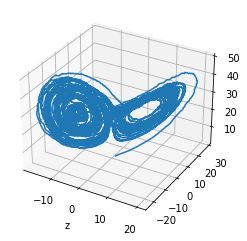

In [8]:
runner = bp.IntegratorRunner(
    lorenz,
    monitors=['x', 'y', 'z'],
    inits=[1., 1., 1.],
    dt=0.001
)
runner.run(50.)

fig = plt.figure()
ax = plt.axes(projection='3d')
plt.plot(runner.mon.x[:, 0], runner.mon.y[:, 0], runner.mon.z[:, 0])
ax.set_xlabel('x')
ax.set_xlabel('y')
ax.set_xlabel('z')
plt.show()

We can also rewrite the above differential equation as a [JointEq](./joint_equations.ipynb) of separable equations, so that it can be applied to Exponential Euler method.

In [9]:
dx = lambda x, t, y: sigma * (y - x)
dy = lambda y, t, x, z: x * (rho - z) - y
dz = lambda z, t, x, y: x * y - beta * z
lorenz_f = bp.JointEq(dx, dy, dz)

  0%|          | 0/50000 [00:00<?, ?it/s]

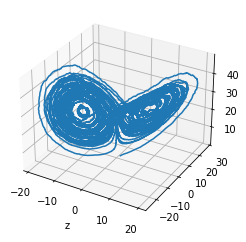

In [10]:
lorenz = bp.sdeint(f=lorenz_f,
                   g=lorenz_g,
                   intg_type=bp.integrators.ITO_SDE,
                   wiener_type=bp.integrators.SCALAR_WIENER,
                   method='exp_euler')

runner = bp.IntegratorRunner(
    lorenz, monitors=['x', 'y', 'z'], inits=[1., 1., 1.], dt=0.001
)
runner.run(50.)

plt.figure()
ax = plt.axes(projection='3d')
plt.plot(runner.mon.x[:, 0], runner.mon.y[:, 0], runner.mon.z[:, 0])
ax.set_xlabel('x')
ax.set_xlabel('y')
ax.set_xlabel('z')
plt.show()

## Supported SDE Numerical Methods 

`BrainPy` provides several numerical methods for stochastic differential equations (SDEs). Specifically, we provide explicit Runge-Kutta methods, derivative-free Milstein methods, and exponential Euler method for SDE numerical integration. 

| Methods                                                                                                       | Keywords           | Ito SDE support | Stratonovich SDE support | Scalar Wiener support | Vector Wiener support |
|---------------------------------------------------------------------------------------------------------------| ------------------ | --------------- | ------------------------ | --------------------- | --------------------- |
| [Strong SRK scheme: SRI1W1](../apis/auto/integrators/generated/brainpy.integrators.sde.srk_scalar.SRK1W1.rst) | srk1w1_scalar     | Yes             |                          | Yes                   |                       |
| [Strong SRK scheme: SRI2W1](../apis/auto/integrators/generated/brainpy.integrators.sde.srk_scalar.SRK2W1.rst) | srk2w1_scalar     | Yes             |                          | Yes                   |                       |
| [Strong SRK scheme: KlPl](../apis/auto/integrators/generated/brainpy.integrators.sde.srk_scalar.KlPl.rst)     | KlPl_scalar       | Yes             |                          | Yes                   |                       |
| [Euler method](../apis/auto/integrators/generated/brainpy.integrators.sde.normal.Euler.rst)                   | euler              | Yes             | Yes                      | Yes                   | Yes                   |
| [Heun method](../apis/auto/integrators/generated/brainpy.integrators.sde.normal.Heun.rst)                            | heun               |                 | Yes                      | Yes                   | Yes                   |
| [Milstein](../apis/auto/integrators/generated/brainpy.integrators.sde.normal.Milstein.rst)           | milstein           | Yes             | Yes                      | Yes                   | Yes                   |
| [Derivative-free Milstein](../apis/auto/integrators/generated/brainpy.integrators.sde.normal.MilsteinGradFree.rst)           | milstein_grad_free           | Yes             | Yes                      | Yes                   | Yes                   |
| [Exponential Euler](../apis/auto/integrators/generated/brainpy.integrators.sde.normal.ExponentialEuler.rst)          | exp_euler | Yes             |                          | Yes                   | Yes                   |